In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

## Train Set

In [2]:
train_dataset = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")

In [3]:
pd.options.display.float_format = '{:.3f}'.format # Set display option for 3 decimal places
train_dataset.describe()

,id,cap-diameter,stem-height,stem-width
count,3116945.000,3116941.000,3116945.000,3116945.000
mean,1558472.000,6.310,6.348,11.154
std,899784.662,4.658,2.700,8.095
min,0.000,0.030,0.000,0.000
25%,779236.000,3.320,4.670,4.970
50%,1558472.000,5.750,5.880,9.650
75%,2337708.000,8.240,7.410,15.630
max,3116944.000,80.670,88.720,102.900


In [4]:
train_dataset.isnull().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

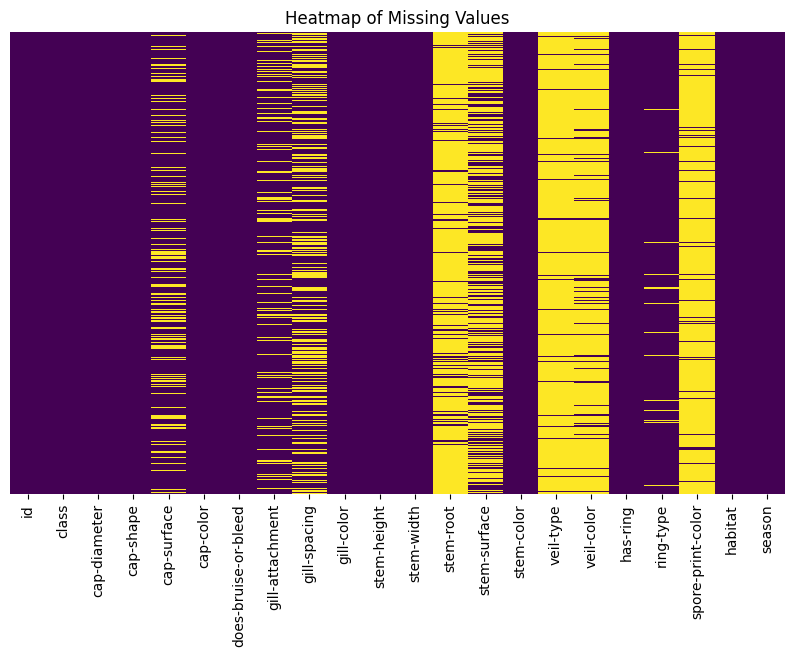

In [12]:
# Create a heatmap to visualize the null values
plt.figure(figsize=(10, 6))
sb.heatmap(train_dataset.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()

In [5]:
train_dataset.drop(['cap-surface','gill-attachment','gill-spacing','stem-root','stem-surface','veil-type','veil-color','ring-type', 'spore-print-color'], axis=1,inplace=True)

In [55]:
X = train_dataset.drop(['id', 'class'], axis=1)
y = train_dataset['class']

#df = df.dropna() drop rows with missing values
#df = df.dropna(axis=1) drop columns with missing values

In [7]:
X.isnull().sum()

cap-diameter             4
cap-shape               40
cap-color               12
does-bruise-or-bleed     8
gill-color              57
stem-height              0
stem-width               0
stem-color              38
has-ring                24
habitat                 45
season                   0
dtype: int64

In [8]:
# Impute missing numerical values
X['cap-diameter'].fillna(X['cap-diameter'].mean(), inplace=True)  # Fill with mean
# X['stem-height'].fillna(X['stem-height'].median(), inplace=True)  # Fill with median
# X['stem-width'].fillna(0, inplace=True)  # Fill with a specific value

/tmp/ipykernel_33/3736655323.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['cap-diameter'].fillna(X['cap-diameter'].mean(), inplace=True)  # Fill with mean


In [10]:
X.isnull().sum()

cap-diameter             0
cap-shape               40
cap-color               12
does-bruise-or-bleed     8
gill-color              57
stem-height              0
stem-width               0
stem-color              38
has-ring                24
habitat                 45
season                   0
dtype: int64

In [11]:
X['cap-shape'].fillna(X['cap-shape'].mode()[0], inplace=True)  # Fill with mode
X['cap-color'].fillna(X['cap-color'].mode()[0], inplace=True)
X['does-bruise-or-bleed'].fillna(X['does-bruise-or-bleed'].mode()[0], inplace=True)
X['gill-color'].fillna(X['gill-color'].mode()[0], inplace=True)
X['stem-color'].fillna(X['stem-color'].mode()[0], inplace=True)
X['has-ring'].fillna(X['has-ring'].mode()[0], inplace=True)
X['habitat'].fillna(X['habitat'].mode()[0], inplace=True)
# X['cap-color'].fillna('unknown', inplace=True)  # Fill with a specific category

/tmp/ipykernel_33/2003947224.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['cap-shape'].fillna(X['cap-shape'].mode()[0], inplace=True)  # Fill with mode
/tmp/ipykernel_33/2003947224.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(

In [12]:
X.isnull().sum()

cap-diameter            0
cap-shape               0
cap-color               0
does-bruise-or-bleed    0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
habitat                 0
season                  0
dtype: int64

In [13]:
X.sample(5)

,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-height,stem-width,stem-color,has-ring,habitat,season
797491,6.600,s,n,f,y,5.720,14.730,y,f,d,a
2677685,1.610,c,n,f,g,5.280,1.640,g,f,d,u
3097193,2.630,b,p,f,y,4.890,5.520,r,f,d,a
3046229,7.410,f,n,f,w,7.180,10.000,w,f,d,a
1916068,16.800,f,k,f,y,5.240,18.010,w,f,d,a


In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   cap-diameter          float64
 1   cap-shape             object 
 2   cap-color             object 
 3   does-bruise-or-bleed  object 
 4   gill-color            object 
 5   stem-height           float64
 6   stem-width            float64
 7   stem-color            object 
 8   has-ring              object 
 9   habitat               object 
 10  season                object 
dtypes: float64(3), object(8)
memory usage: 261.6+ MB


In [15]:
from category_encoders.ordinal import OrdinalEncoder

oe = OrdinalEncoder()
X_encoded = oe.fit_transform(X)

In [16]:
# X_encoded = pd.DataFrame(X_encoded, columns=X.columns)
X_encoded.sample(10)

,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-height,stem-width,stem-color,has-ring,habitat,season
1086766,11.030,2,5,1,5,7.740,17.100,3,1,1,1
1173421,5.850,2,6,1,1,5.270,9.200,3,1,2,1
1421855,3.790,2,6,1,2,4.740,10.290,3,1,1,1
497661,4.930,1,4,1,5,4.280,7.680,1,1,1,1
1257911,1.300,6,6,1,1,4.750,1.660,9,1,2,3
796643,8.720,2,8,2,5,8.280,16.960,4,1,1,3
165726,10.290,7,5,2,1,5.210,22.970,1,1,1,1
806744,8.980,2,6,2,7,8.780,17.110,1,2,2,1
2565979,12.720,2,4,1,1,11.470,16.280,1,2,1,3
3071078,3.260,2,6,1,4,6.040,5.240,1,1,1,2


In [17]:
oe_y = OrdinalEncoder()
y_encoded = oe_y.fit_transform(y)

In [18]:
y_encoded.sample(10)

,class
2577150,2
337516,1
2293881,2
435426,2
2389719,1
3006647,1
591155,2
363565,2
2307182,1
3045770,1


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=1) #randomly slpit (random_state=1?)

In [20]:
X_train.head(5)

,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-height,stem-width,stem-color,has-ring,habitat,season
596504,1.740,2,6,1,2,5.410,2.740,3,1,3,3
580459,2.170,2,2,1,5,2.780,4.990,4,1,1,3
115675,1.760,1,6,1,2,5.370,2.740,4,1,3,1
1427581,4.350,2,6,1,2,5.240,6.250,2,2,1,3
2933369,6.350,2,6,1,1,14.250,12.420,3,1,4,1


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numerical_cols = ['cap-diameter','stem-height', 'stem-width']
ct = ColumnTransformer(transformers=[('feature_scaler', StandardScaler(), numerical_cols)] , remainder='passthrough' )

X_train = ct.fit_transform(X_train)

In [23]:
X_test = ct.transform(X_test)

# KNN Classifier

In [47]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_classifier.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [48]:
y_pred_knn = knn_classifier.predict(X_test)

In [49]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn, normalize='true')

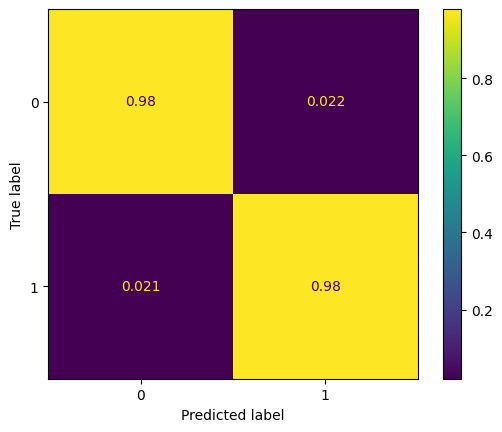

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
# TN FN
# FP TP

In [51]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred_knn)

0.9571407232016286


# Naive Bias Classifier

In [35]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_gnb, normalize='true')

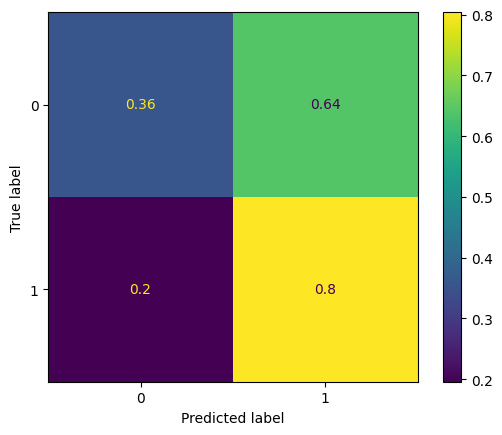

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
# TN FN
# FP TP

In [38]:
matthews_corrcoef(y_test, y_pred_gnb)

0.18349149656022734

# RandomForest Classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
rf_classifier = RandomForestClassifier(n_estimators=10)

In [42]:
rf_classifier.fit(X_train, y_train)

/tmp/ipykernel_33/31409248.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


RandomForestClassifier(n_estimators=10)

In [43]:
y_pred_rf = rf_classifier.predict(X_test)

In [44]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_gnb, normalize='true')

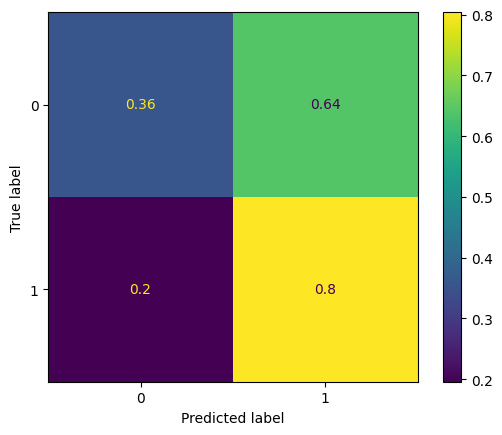

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
# TN FN
# FP TP

In [46]:
matthews_corrcoef(y_test, y_pred_gnb)

0.18349149656022734

# Using KNN classifier for final submission

In [52]:
test_dataset = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")
test_dataset.drop(['cap-surface','gill-attachment','gill-spacing','stem-root','stem-surface','veil-type','veil-color','ring-type', 'spore-print-color'], axis=1,inplace=True)

In [56]:
X_submission = test_dataset.drop(['id'], axis=1)

In [79]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077964 entries, 0 to 2077963
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-color             object 
 4   does-bruise-or-bleed  object 
 5   gill-color            object 
 6   stem-height           float64
 7   stem-width            float64
 8   stem-color            object 
 9   has-ring              object 
 10  habitat               object 
 11  season                object 
dtypes: float64(3), int64(1), object(8)
memory usage: 190.2+ MB


In [57]:
X_submission.isnull().sum()

cap-diameter             7
cap-shape               31
cap-color               13
does-bruise-or-bleed    10
gill-color              49
stem-height              1
stem-width               0
stem-color              21
has-ring                19
habitat                 25
season                   0
dtype: int64

In [60]:
# Impute missing numerical values
X_submission['cap-diameter'].fillna(X_submission['cap-diameter'].mean(), inplace=True)  # Fill with mean
X_submission['stem-height'].fillna(X_submission['stem-height'].mean(), inplace=True)  # Fill with median
# X['stem-width'].fillna(0, inplace=True)  # Fill with a specific value

/tmp/ipykernel_33/29306147.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_submission['cap-diameter'].fillna(X_submission['cap-diameter'].mean(), inplace=True)  # Fill with mean
/tmp/ipykernel_33/29306147.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

In [61]:
X_submission.isnull().sum()

cap-diameter             0
cap-shape               31
cap-color               13
does-bruise-or-bleed    10
gill-color              49
stem-height              0
stem-width               0
stem-color              21
has-ring                19
habitat                 25
season                   0
dtype: int64

In [62]:
X_submission['cap-shape'].fillna(X_submission['cap-shape'].mode()[0], inplace=True)  # Fill with mode
X_submission['cap-color'].fillna(X_submission['cap-color'].mode()[0], inplace=True)
X_submission['does-bruise-or-bleed'].fillna(X_submission['does-bruise-or-bleed'].mode()[0], inplace=True)
X_submission['gill-color'].fillna(X_submission['gill-color'].mode()[0], inplace=True)
X_submission['stem-color'].fillna(X_submission['stem-color'].mode()[0], inplace=True)
X_submission['has-ring'].fillna(X_submission['has-ring'].mode()[0], inplace=True)
X_submission['habitat'].fillna(X_submission['habitat'].mode()[0], inplace=True)
# X['cap-color'].fillna('unknown', inplace=True)  # Fill with a specific category

/tmp/ipykernel_33/709174590.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_submission['cap-shape'].fillna(X_submission['cap-shape'].mode()[0], inplace=True)  # Fill with mode
/tmp/ipykernel_33/709174590.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

In [63]:
X_submission.isnull().sum()

cap-diameter            0
cap-shape               0
cap-color               0
does-bruise-or-bleed    0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
habitat                 0
season                  0
dtype: int64

In [64]:
oe_submission = OrdinalEncoder()
X_encoded_submission = oe_submission.fit_transform(X_submission)

In [66]:
numerical_cols = ['cap-diameter','stem-height', 'stem-width']
ct_submission = ColumnTransformer(transformers=[('feature_scaler_submission', StandardScaler(), numerical_cols)] , remainder='passthrough' )

X_submission = ct_submission.fit_transform(X_encoded_submission)

In [67]:
y_pred_knn_submission = knn_classifier.predict(X_submission)

In [75]:
pred = pd.DataFrame({'class': y_pred_knn_submission})
predictions = oe_y.inverse_transform(pred)

In [77]:
predictions.tail(10)

,class
2077954,e
2077955,p
2077956,p
2077957,p
2077958,e
2077959,e
2077960,e
2077961,p
2077962,e
2077963,e


In [80]:
predictions.to_csv('submission_by_KNN.csv', index=False)